In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

In [33]:
# Prepocessing data
# Source lecture DAT200. File: rawDataInspection_01.py

In [34]:
df = pd.read_csv('CA3-train.csv')

In [35]:
# Search for missing values
missing = np.asarray(df.isnull().sum())
if missing.any():
    print("Dataset has missing values")
else:
    print('No missing values!')

No missing values!


In [36]:
# features index
c_first = 1
c_last = 25    # not included
# Assign features to X matrix and corresponding labels to vector y
X, y = df.iloc[:, c_first:c_last].values, df.iloc[:, 25]
print(f"Selected features:", df.iloc[:, c_first:c_last].columns)

Selected features: Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11',
       'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24'],
      dtype='object')


In [37]:
# print out the unique class labels
np.unique(y)

array([0., 1., 2.])

In [38]:
# Default parameters
seed = 1
test_size = 0.3

# Splitting data with default parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y,
                                                    random_state=seed)

# Standardizing our data to make algorithms behave better
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [39]:
# Function to plot decision regions. Works only when two features are selected
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # Source Python for Machine Learning ch05
    # setup marker generator and colormap
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx2.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot examples by class
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')
    plt.xlabel('First feature [standardized]')
    plt.ylabel('Second feature [standardized]')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [40]:
def combined(X_train, X_test, y_train, y_test):
    # Stacking the data before plotting
    X_combined = X_train + X_test
    y_combined = y_train + y_test
    return X_combined, y_combined

In [90]:
def fit_test_size(classifier, X, y, test_size_list, seed, feature_extraction=None, n_components=None):
    # Accuracy for different test_train_splits
    for size in test_size_list:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y,
                                                            random_state=seed)
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        if feature_extraction == PCA:
            # Dimensionality reduction through PCA
            pca = PCA(n_components=n_components, random_state=1)
            X_train_pca = pca.fit_transform(X_train_std, y_train)
            X_test_pca = pca.transform(X_test_std)
            classifier.fit(X_train_pca, y_train)
            y_pred = classifier.predict(X_test_pca)
            print(f'Misclassified examples PCA: {(y_test != y_pred).sum()}')
            print('Accuracy PCA: {:.3}'.format(classifier.score(X_test_pca, y_test)))
            print(f'Test size: {size}')
        elif feature_extraction == LDA:
            lda = LDA(n_components=n_components)
            X_train_lda = lda.fit_transform(X_train_std, y_train)
            X_test_lda = lda.transform(X_test_std)
            classifier.fit(X_train_lda, y_train)
            print('Accuracy LDA: {:.3}'.format(classifier.score(X_test_lda, y_test)))
            print(f'Test size: {size}')
                
        else:
            classifier.fit(X_train_std, y_train)
            y_pred = classifier.predict(X_test_std)
            print(f'Misclassified examples: {(y_test != y_pred).sum()}')
            print('Training Accuracy: {:.3}'.format(classifier.score(X_train_std, y_train)))
            print('Accuracy: {:.3}'.format(classifier.score(X_test_std, y_test)))
            print(f'Test size: {size}')
    # Note: After function call test size is the last index of test_size_list

In [91]:
# plot cumulative sum of explained variances
def plot_var_exp(n_components):
    pca = PCA(n_components=n_components, random_state=1)
    pca.fit_transform(X_train_std)
    pca.fit(X_test_std)
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1, n_components + 1), var_exp, alpha=0.5, align='center',
            label='Individual explained variances')
    plt.step(range(1, n_components + 1), cum_var_exp, where='mid',
             label='Cumulative explained variances')
    plt.xlabel('Explained variance ratio')
    plt.ylabel('Principal component index')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [93]:
# Fit decision tree classifier and calculate accuracy for different train_test_splits
C_list = [100, 10, 1, 0.1, 0.01]
max_score = 0
for C in C_list:
    lr_temp = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=seed)
    lr_temp.fit(X_train_std, y_train)
    score = lr_temp.score(X_test_std, y_test)
    if score > max_score:
        max_score = score
        C_best = C

print("Best C: ", C_best)
print("Max acurracy score: {:.3}".format(max_score))
print("Test size: ", test_size)

Best C:  0.1
Max acurracy score: 0.488
Test size:  0.3


In [94]:
# Fit Decision tree and calculate accuracy for different train_test_splits
test_size_list = [0.6, 0.3, 0.1, 0.05, 0.01]
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3)

In [95]:
# Fit Decision tree and calculate accuracy for different train_test_splits
test_size_list = [0.6, 0.3, 0.1, 0.05, 0.01]
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=3, min_weight_fraction_leaf=0.2, 
                                    random_state=seed)
fit_test_size(tree_model, X, y, test_size_list, seed)

Misclassified examples: 2250
Training Accuracy: 0.459
Accuracy: 0.472
Test size: 0.6
Misclassified examples: 1120
Training Accuracy: 0.483
Accuracy: 0.475
Test size: 0.3
Misclassified examples: 351
Training Accuracy: 0.476
Accuracy: 0.506
Test size: 0.1
Misclassified examples: 170
Training Accuracy: 0.477
Accuracy: 0.522
Test size: 0.05
Misclassified examples: 41
Training Accuracy: 0.479
Accuracy: 0.431
Test size: 0.01


In [96]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
tree_model.fit(X_train_lda, y_train)
print('Accuracy LDA: {:.3}'.format(tree_model.score(X_test_lda, y_test)))
print(f'Test size: {test_size}')

Accuracy LDA: 0.501
Test size: 0.3


In [97]:
# Calculate accuracy with feature extraction
fit_test_size(tree_model, X, y, test_size_list, seed, feature_extraction=LDA, n_components=2)

Accuracy LDA: 0.494
Test size: 0.6
Accuracy LDA: 0.501
Test size: 0.3
Accuracy LDA: 0.506
Test size: 0.1
Accuracy LDA: 0.528
Test size: 0.05
Accuracy LDA: 0.514
Test size: 0.01


In [98]:
# Calculate accuracy with feature extraction
fit_test_size(tree_model, X, y, test_size_list, seed, feature_extraction=PCA, n_components=2)

Misclassified examples PCA: 2543
Accuracy PCA: 0.404
Test size: 0.6
Misclassified examples PCA: 1248
Accuracy PCA: 0.415
Test size: 0.3
Misclassified examples PCA: 412
Accuracy PCA: 0.421
Test size: 0.1
Misclassified examples PCA: 211
Accuracy PCA: 0.407
Test size: 0.05
Misclassified examples PCA: 44
Accuracy PCA: 0.389
Test size: 0.01


### Looking into the data

comment: Might skip this in final version

* Search for correlations
* Look for outliers
* Visualize

In [71]:
df_X = df.iloc[:, 1:25]

In [72]:
# =============================================================================
# Descriptive statistics
# =============================================================================
df_X.describe()
#df.iloc[:, 16].describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
count,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,...,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000,7108.000000
mean,1.202026,0.804586,0.401941,156.874930,166.643360,196.047271,168.302195,238.272512,230.066717,219.825159,...,0.398284,530.048818,0.224254,297.630979,0.221186,0.331006,0.030905,5.881964,4.886747,2.899268
std,0.493933,0.396547,0.490325,80.914806,74.588417,107.521931,77.616408,207.299347,207.017288,198.373088,...,0.707898,1927.718921,0.417120,699.293958,0.376378,0.451033,0.027579,1.536845,2.878474,1.860700
min,1.000000,0.000000,0.000000,0.000000,20.000000,20.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-4.325500,-1.206000,0.000500,2.000000,1.000000,1.000000
25%,1.000000,1.000000,0.000000,99.000000,119.000000,119.000000,119.000000,111.037400,105.016925,88.459000,...,0.000000,0.000000,0.000000,0.000000,0.073800,0.124575,0.015300,5.000000,2.000000,1.000000
50%,1.000000,1.000000,0.000000,139.000000,159.000000,179.000000,159.000000,173.704850,167.636150,150.273100,...,0.000000,0.000000,0.000000,0.000000,0.147800,0.220600,0.023400,6.000000,4.000000,2.000000
75%,1.000000,1.000000,1.000000,199.000000,199.000000,239.000000,199.000000,289.366625,281.537275,284.385325,...,1.000000,223.750000,0.000000,298.000000,0.259100,0.354800,0.036900,7.000000,7.000000,4.000000
max,8.000000,1.000000,1.000000,1036.000000,1036.000000,1628.000000,977.000000,1924.134700,1924.134700,1070.361600,...,5.000000,35448.000000,1.000000,11140.000000,4.491700,4.491700,0.362300,10.000000,10.000000,10.000000


In [73]:
# Check for positive values f16

positive_f16 = np.where(df['f16']>0, True, False)
# count True
positive_f16.sum()

2145

In [74]:
# Drop rows with zero values

extract_positive_f16 = df[df['f16']>0]['f16']
extract_positive_f16

1        5290.0
3         397.0
6        2248.0
11        358.0
12       2306.0
         ...   
7083     1569.0
7089      596.0
7090    10556.0
7099      517.0
7102      477.0
Name: f16, Length: 2145, dtype: float64

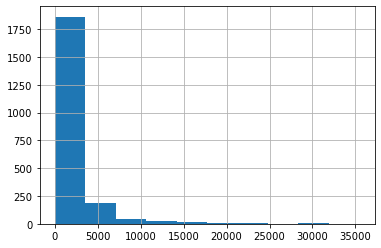

In [75]:
# Histogram positive f16
extract_positive_f16.hist()

In [76]:
# Descriptive statistics for posive f16

extract_positive_f16.describe()

count     2145.000000
mean      1756.450816
std       3187.966249
min         20.000000
25%        318.000000
50%        676.000000
75%       1670.000000
max      35448.000000
Name: f16, dtype: float64

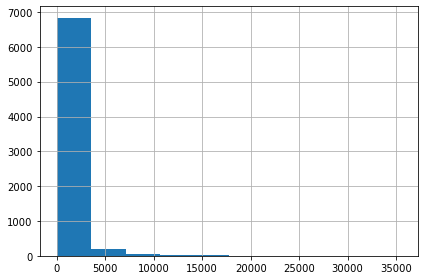

In [77]:
# =============================================================================
# Histograms
# =============================================================================

df.iloc[:, 16].hist()
plt.tight_layout()
plt.show()

Notes AH: Possible outliers f16, very high max relative to the rest.
Also a lot of zero values more than two-thirds. Consider dropping the column.

In [ ]:
# =============================================================================
# Density plots
# =============================================================================

df['f16'].plot(kind='density')
plt.show()

In [78]:
# Sort values for f16 in descending order

df['f16'].sort_values(ascending=False)[0:50]

4366    35448.0
6861    35448.0
3295    30016.0
5336    30016.0
3089    30016.0
3764    30016.0
1108    24987.0
4808    22514.0
1539    22218.0
2019    22218.0
3997    22218.0
2481    22218.0
2160    17872.0
4439    17872.0
4162    17872.0
1876    17019.0
2058    17019.0
6419    15604.0
6589    15604.0
332     15604.0
2150    15319.0
3985    15319.0
2888    15319.0
1597    15319.0
6767    15319.0
4959    15319.0
1870    14971.0
2067    14824.0
4923    14824.0
6088    14824.0
62      14824.0
4543    14146.0
2246    14146.0
6681    14146.0
343     14146.0
1084    14146.0
5137    14146.0
929     14047.0
3443    12433.0
680     12433.0
4793    12433.0
4609    12432.0
5079    12432.0
5633    12364.0
4887    12364.0
4460    12185.0
1720    11988.0
1699    11988.0
1639    11655.0
66      11655.0
Name: f16, dtype: float64

In [ ]:
df.sort_values(by=['f16'], ascending=False)[0:30]

Note: Skip the six first datapoints from the sorting above

In [ ]:
# =============================================================================
# Plot correlation matrix
# =============================================================================

# plot correlation matrix for the first four features
df_sub = df.iloc[:, 21:25]
correlations = df_sub.corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, 5, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(df_sub.columns))
ax.set_yticklabels(list(df_sub.columns))
plt.tight_layout()
plt.show()

In [ ]:
correlations

In [ ]:
corr_f15f16 = df.iloc[:, [15, 16]].corr()
corr_f15f16

In [ ]:
# correlations all f16
corr_all = df_X.corr()
corr_all.iloc[:, 19]

In [ ]:
# Standardizing

sc = StandardScaler()
df_X_std = sc.fit_transform(df_X)
df_X_std


In [ ]:
plt.scatter(df_X_std[14], df_X_std[15])